In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dateparse = lambda x: pd.datetime.strptime(x, '%d-%m-%Y %H:%M')
df = pd.read_csv("Train.csv", parse_dates=['Datetime'], index_col='Datetime', date_parser=dateparse)

In [3]:
df = df.drop("ID", axis=1)

In [55]:
df.index = pd.to_datetime(df.index)

In [56]:
train = df['2014-01-25':'2014-09-09']
test = df['2014-09-10':]



In [57]:
from sklearn.preprocessing import MinMaxScaler

In [58]:
scaler = MinMaxScaler()

In [59]:
train_scaled = scaler.fit_transform(train)

In [60]:
test_scaled = scaler.transform(test)

In [61]:
def next_batch(tdata, batch_size, steps):
    
    rand_start = np.random.randint(0, len(tdata)-steps)
    
    #print(rand_start)
    #print(rand_start+steps+1)
    
    batch = np.array(tdata[rand_start:rand_start+steps+1]).reshape(1, steps+1)
    
    return batch[:,:-1].reshape(-1, steps,1), batch[:,1:].reshape(-1,steps,1)
    

In [62]:
import tensorflow as tf

In [63]:
tf.reset_default_graph()

In [64]:
num_inputs = 1
num_outputs = 1
num_neurons = 100
learning_rate = 0.01
num_steps = 168
num_iter = 4000

In [65]:
X = tf.placeholder(tf.float32, shape=[None, num_steps, num_inputs])
y = tf.placeholder(tf.float32, shape=[None, num_steps, num_outputs])

In [66]:
#RNN

In [67]:
cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.LSTMCell(num_units=num_neurons, 
                                                                      activation=tf.nn.relu), output_size=num_outputs)

In [68]:
output, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [69]:
loss = tf.sqrt(tf.reduce_mean(tf.square(output-y)))

In [70]:
optimizer = tf.train.AdamOptimizer (learning_rate=learning_rate)
train = optimizer.minimize(loss)

In [71]:
init = tf.global_variables_initializer()

In [72]:
saver = tf.train.Saver()

In [73]:
with tf.Session() as sess:
    
    sess.run(init)
    
    for i in range(num_iter):
        y1,y2 = next_batch(train_scaled, 1, num_steps)
        sess.run(train, feed_dict={X:y1, y:y2})
    
   
        if i % 100 == 0:
            y1,y2 = next_batch(test_scaled, 1, num_steps)
            rmse = loss.eval(feed_dict={X:y1, y:y2})
            print(i, "\trmse", rmse)
        
    
    saver.save(sess, "./avtimeseries")

0 	rmse 0.2784
100 	rmse 0.0787549
200 	rmse 0.0704387
300 	rmse 0.0732346
400 	rmse 0.0625852
500 	rmse 0.07015
600 	rmse 0.0599902
700 	rmse 0.0705939
800 	rmse 0.0519696
900 	rmse 0.0602639
1000 	rmse 0.0757587
1100 	rmse 0.0660442
1200 	rmse 0.0747903
1300 	rmse 0.0712007
1400 	rmse 0.0714435
1500 	rmse 0.0638834
1600 	rmse 0.0694249
1700 	rmse 0.0521944
1800 	rmse 0.0537344
1900 	rmse 0.0727353
2000 	rmse 0.0685105
2100 	rmse 0.0619101
2200 	rmse 0.0676403
2300 	rmse 0.0599403
2400 	rmse 0.0549916
2500 	rmse 0.0726817
2600 	rmse 0.0681138
2700 	rmse 0.0610273
2800 	rmse 0.0607308
2900 	rmse 0.0555352
3000 	rmse 0.0518246
3100 	rmse 0.05654
3200 	rmse 0.0544244
3300 	rmse 0.0524324
3400 	rmse 0.0698735
3500 	rmse 0.0554502
3600 	rmse 0.0769198
3700 	rmse 0.0746828
3800 	rmse 0.0570033
3900 	rmse 0.0524984


In [74]:
num_iter = num_steps

In [75]:
with tf.Session() as sess:
    
    saver.restore(sess,"./avtimeseries")
    
    t_inst = list(train_scaled[-num_steps:])
    
    for i in range(num_iter):
        
        x_batch = np.array(t_inst[-num_steps:]).reshape(1, num_steps, 1)
        y_pred = sess.run(output, feed_dict={X:x_batch})
       
        
        t_inst.append(y_pred[0,-1,0])
        

INFO:tensorflow:Restoring parameters from ./avtimeseries


In [76]:
results = scaler.inverse_transform(np.array(t_inst[num_steps:]).reshape(num_iter,1))

In [77]:
test2 = test['2014-09-10':'2014-09-16']

In [78]:
test2['generated'] = results

c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [79]:
test2

,Count,generated
Datetime,,
2014-09-10 00:00:00,456,516.927490
2014-09-10 01:00:00,374,425.700714
2014-09-10 02:00:00,308,353.440826
2014-09-10 03:00:00,198,307.559052
2014-09-10 04:00:00,194,305.881287
2014-09-10 05:00:00,198,339.171875
2014-09-10 06:00:00,184,383.825958
2014-09-10 07:00:00,256,430.207062
2014-09-10 08:00:00,314,498.120453


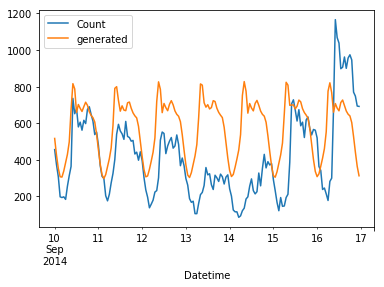

In [80]:
test2.plot()

In [81]:
with tf.Session() as sess:
    print(sess.run(tf.sqrt(tf.reduce_mean(tf.square(test2['Count'] - test2['generated'])))))

277.834585246


In [82]:
dateparse = lambda x: pd.datetime.strptime(x, '%d-%m-%Y %H:%M')
tdf = pd.read_csv("Test.csv", parse_dates=['Datetime'], index_col='Datetime', date_parser=dateparse)

In [ ]:
num_test_iter = 5112

In [ ]:
with tf.Session() as sess:
    
    saver.restore(sess,"./avtimeseries")
    
    t_inst1 = list(test_scaled[-num_steps:])
    
    for i in range(num_test_iter):
        
        x_batch = np.array(t_inst1[-num_steps:]).reshape(1, num_steps, 1)
        y_pred = sess.run(output, feed_dict={X:x_batch})
       
        
        t_inst1.append(y_pred[0,-1,0])
        

INFO:tensorflow:Restoring parameters from ./avtimeseries


In [ ]:
resulttest = scaler.inverse_transform(np.array(t_inst1[num_steps:]).reshape(num_test_iter,1))

In [ ]:
resulttest

In [ ]:
tdf['Count'] = resulttest

In [ ]:
tdf.head(20)

In [ ]:
tdf.to_csv("./sub.csv")